In [21]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-024db545-f852-7129-a05b-58041bdc0cbb)


In [22]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# dataset qui contient les donnees constantes
MASKdataset = xr.open_dataset('/gpfswork/idris/sos/ssos025/HRMES/MLspinup/INPUTS/eORCA1.2_mesh_mask.nc',decode_times=False)

# dataset qui contient les donnees qui varient dans le temps, ie les courants 3D
Udataset = xr.open_dataset('/gpfswork/idris/sos/ssos025/HRMES/CM65v42b-LR-pi-06_18500101_18591231_1M_grid_U.nc',decode_times=False)

/gpfslocalsup/pub/anaconda-py3/2021.05/envs/pytorch-gpu-1.10.0+py3.9.7/lib/python3.9/site-packages/xarray/backends/plugins.py:65: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [47]:
def compute_one_instance(u, e2u, e3u):
    U = np.squeeze(np.sum(u * e3u,axis=0))
    U = np.pad(U, ((0, 1), (1, 1)))
    U = U * e2u # barotropic zonal velocity in m3/s
    MSFT = np.zeros(np.shape(U))
    MSFT[:,:] = np.cumsum(U[:,:],axis=0)
    MSFT[:,:] = MSFT[:,:] - MSFT[300,50] # ici on retire partout la valeur dans la terre, prise à j=300, i=50 pour cette configuration
    return MSFT

In [63]:
def compute_all(u, e2u, e3u):
    U = np.sum(u * e3u, axis=1)
    U = np.pad(U, ((0, 0), (0, 1), (1, 1)))
    U = U * e2u.to_numpy()
    MSFT = np.cumsum(U, axis=1)
    MSFT -= MSFT[:, 300:301, 50:51]
    return MSFT

import time
t = time.time()
MSFT_all = compute_all(Udataset.uo, MASKdataset.e2u, Udataset.e3u) * MASKdataset.fmask[0:1, 0, :, :].to_numpy()
print(time.time() - t)

5.8471596240997314


In [58]:
MASKdataset.e2u.expand_dims((120,), 0).shape

(1, 1, 332, 362)

In [50]:
Udataset.uo.shape, MASKdataset.e2u.shape, Udataset.e3u.shape, MASKdataset.fmask.shape

((120, 75, 331, 360), (1, 332, 362), (120, 75, 331, 360), (1, 75, 332, 362))

In [52]:
t_ = time.time()
MSFT = np.zeros((120,332,362)) # calcul ici pour 120 mois
for t in range(0,120,1):
    MSFT[t,:,:] = compute_one_instance(np.squeeze(Udataset.uo[t,:,:,:]),np.squeeze(MASKdataset.e2u),np.squeeze(Udataset.e3u[t,:,:,:])) * MASKdataset.fmask[0,0,:,:]
print(time.time() - t_)

5.9868104457855225


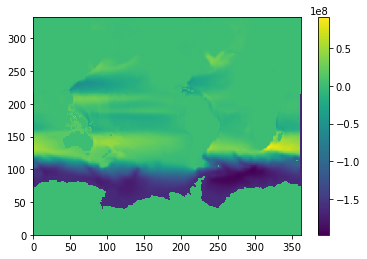

In [5]:
plt.pcolor(np.mean(MSFT,axis=0)) # trace la moyenne temporelle
plt.colorbar()

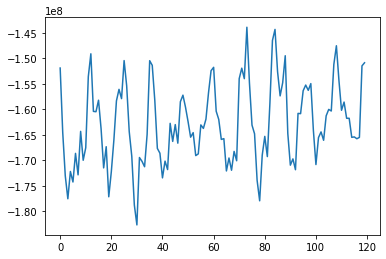

In [6]:
plt.plot(MSFT[:,48,110])

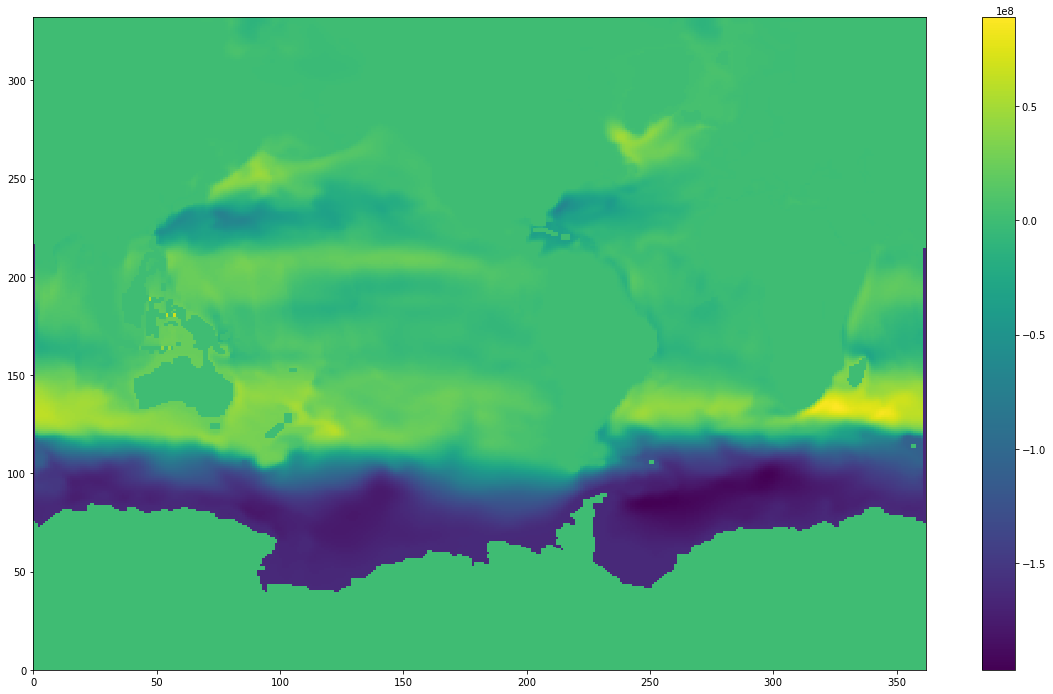

In [10]:
plt.figure(figsize=(20, 12)) ; plt.pcolor(MSFT[1, :, :]) ; plt.colorbar() ; plt.show()

In [71]:
!getfacl /gpfsstore/rech/gzi/rgzi002/IGCM_OUT/IPSLCM6/DEVT/piControl/CM65v42b-LR-pi-06/OCE/Output/MO/CM65v42b-LR-pi-06_18500101_18591231_1M_diaptr_T_2D.nc

getfacl: Removing leading '/' from absolute path names
# file: gpfsstore/rech/gzi/rgzi002/IGCM_OUT/IPSLCM6/DEVT/piControl/CM65v42b-LR-pi-06/OCE/Output/MO/CM65v42b-LR-pi-06_18500101_18591231_1M_diaptr_T_2D.nc
# owner: rgzi002
# group: gzi
user::rwx
user:ssos025:rwx
group::r--
mask::rwx
other::r--



In [66]:
!ls -l /gpfsstore/rech/gzi/rgzi002/IGCM_OUT/IPSLCM6/DEVT/piControl/CM65v42b-LR-pi-06/OCE/Output/MO

total 1014581840
-rwxrwxr--+ 1 rgzi002 gzi     6378875 Jun  5  2021 CM65v42b-LR-pi-06_18500101_18591231_1M_diaptr_T_2D.nc
-rwxrwxr--+ 1 rgzi002 gzi    82628029 Jun  5  2021 CM65v42b-LR-pi-06_18500101_18591231_1M_diaptr_T_3D.nc
-rwxrwxr--+ 1 rgzi002 gzi    17890753 Jun  5  2021 CM65v42b-LR-pi-06_18500101_18591231_1M_diaptr_W.nc
-rwxrwxr--+ 1 rgzi002 gzi  8649133745 Jun  5  2021 CM65v42b-LR-pi-06_18500101_18591231_1M_grid_T.nc
-rwxrwxr--+ 1 rgzi002 gzi  5962467303 Jun  5  2021 CM65v42b-LR-pi-06_18500101_18591231_1M_grid_U.nc
-rwxrwxr--+ 1 rgzi002 gzi  6170890129 Jun  5  2021 CM65v42b-LR-pi-06_18500101_18591231_1M_grid_V.nc
-rwxrwxr--+ 1 rgzi002 gzi 26412534409 Jun  5  2021 CM65v42b-LR-pi-06_18500101_18591231_1M_grid_W.nc
-rwxrwxr--+ 1 rgzi002 gzi      451364 Jun  5  2021 CM65v42b-LR-pi-06_18500101_18591231_1M_scalar.nc
-rwxrwxr--+ 1 rgzi002 gzi       62121 Jun  5  2021 CM65v42b-LR-pi-06_18500101_18591231_1M_strait_oce.nc
-rwxrwxr--+ 1 rgzi002 gzi 13839847722 Jun  5  2021 CM65v42b-LR-pi-0